# Paper Figures Notebook

This Jupyter notebook contains the messier scripts used to create the figures used in the actual project write up.

In [66]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mplhep as hep
import labellines
plt.style.use(hep.style.ROOT)

In [67]:
def discretized_schrodinger(potentialFunction, initialBoundaryPoint: float, finalBoundaryPoint: float, numPosSteps: int, numEigVals: int, mass: float, hbar=1.0):
    # Calculate discretized points and spacing for [a,a+dx,a+2dx,...,b-dx,b]
    xs = np.linspace(initialBoundaryPoint,finalBoundaryPoint,numPosSteps+2)
    dx = np.diff(xs)[0]

    # Compute potential along discretized points
    Vx = potentialFunction(xs)

    # Calculate main diagonal, trimming out end points where we should have psi(a)=psi(b)=0
    main_diag = (np.power(dx,-2.0) + mass * Vx)[1:-1]
    # Calculate sub/supradiagonal terms, constants defined by dx
    off_diag  = np.power(dx,-2.0) * -0.5 * np.ones(len(main_diag)-1)

    # Solve eigensystem using assumption matrix is symmetric tridiagonal,
    # only return first numEigvals to cut down on unnecessary computation
    eigvals, eigstates = sp.linalg.eigh_tridiagonal(
        d            = main_diag,
        e            = off_diag,
        eigvals_only = False,
        select       = 'i',
        select_range = (0,numEigVals-1)
    )

    # Returns two elements including list of energy eigenvalues with shape (numEigVals,)
    # as well as a list of eigenstates with shape (numEigVals,numPosSteps)
    return (hbar/mass)*eigvals, eigstates.T

# Nice hex codes general plotting
colors = [
    "#332288",  # Blue
    "#117733",  # Green
    "#44AA99",  # Teal
    "#88CCEE",  # Sky blue
    "#DDCC77",  # Sand
    "#CC6677",  # Rose
    "#AA4499",  # Purple
    "#882255",  # Wine
    "#999933",  # Olive
    "#E69F00",  # Orange
]

linestyles = [
    '--', '-.', ':', 
    (0, (5, 1)), 
    (0, (3, 5, 1, 5)), 
    (0, (1, 1)), 
    (0, (4, 2)), 
    (0, (2, 2)), 
    (0, (8, 4, 2, 4)), 
    (0, (6, 2, 1, 2))
]

## Harmonic Oscillator

In [68]:
hbar  = 1
omega = 1
a     = -15
b     = 15
n     = 10
m     = 1

def harmonic_oscillator(x): return (m/2)*np.power(omega*x,2)

Ns = np.array([int(x) for x in [10,20,30,40,50,1e2,1e3,1e4,1e5,1e6,1e7]])
NStrings = ['10','20','30','40','50','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$','$10^7$']
true_ho_vals = [hbar*omega*(n+0.5) for n in range(0,10)]

#Stores eigenvalues in a 2d list (m,n) where row m changes number of time steps, and column n is the n-th eigenvalue
discrete_HO_evalues = []
#Stores eigenstates in a 3d list where (m,n,o) where row m changes number of pos steps, column n is the n-th state
# and the third column o corresponds to the state's value at that step position
discrete_HO_estates = []

for N in Ns:
    HO_vals, HO_states = discretized_schrodinger(harmonic_oscillator,
                                                a,
                                                b,
                                                N,
                                                n,
                                                m)
    discrete_HO_evalues.append(HO_vals)
    discrete_HO_estates.append(HO_states)

/Users/aidan/miniconda3/envs/adc/lib/python3.11/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(None), but could not find a label for it.
  warnings.warn(


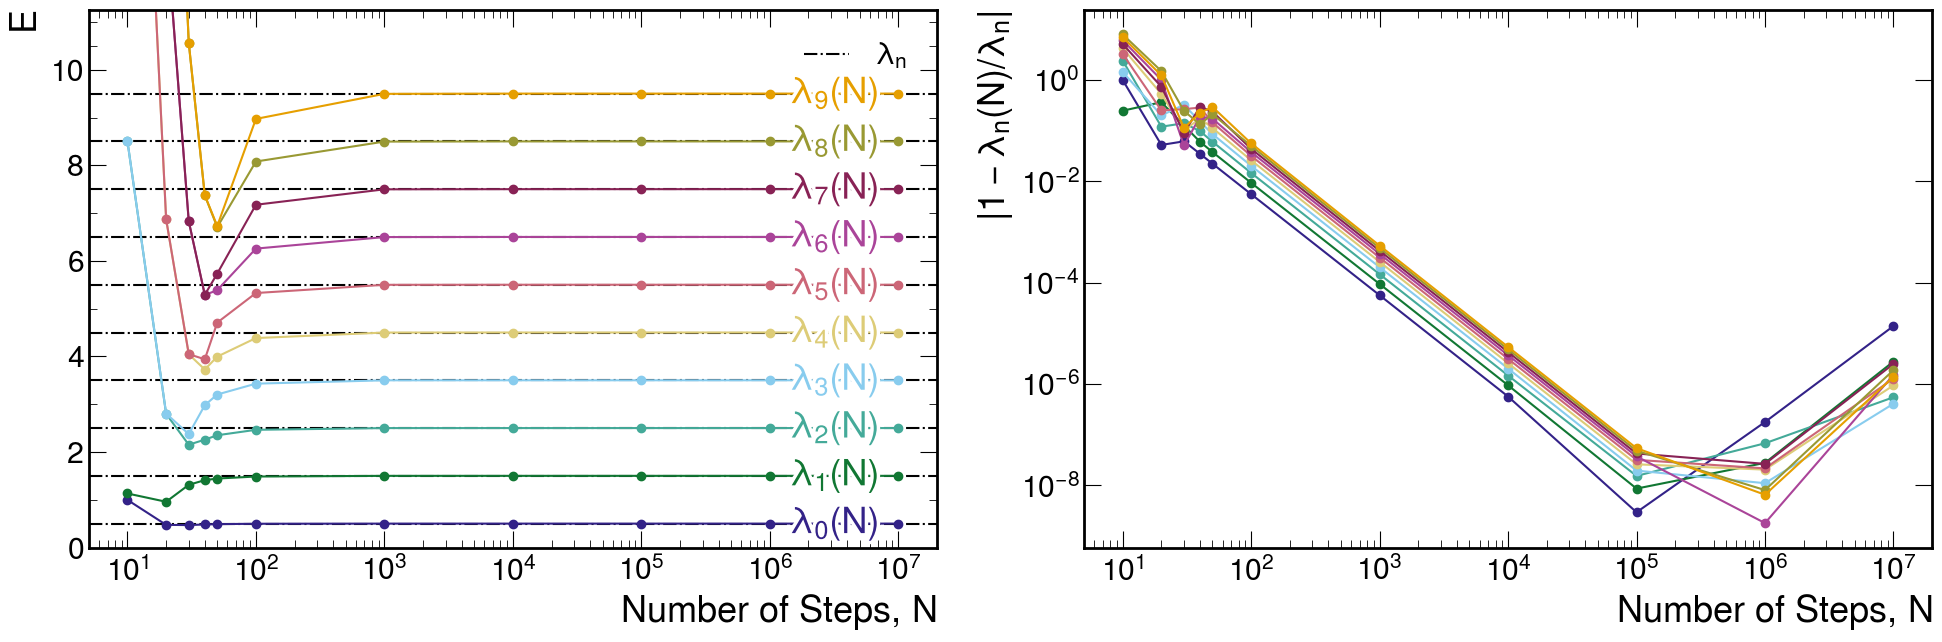

In [69]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

for i in range(len(true_ho_vals)):
    if i==0:
        axs[0].axhline(true_ho_vals[i],color='black',linewidth=1.5,linestyle='-.',label=r'$\lambda_n$')
    else:
        axs[0].axhline(true_ho_vals[i],color='black',linewidth=1.5,linestyle='-.')

lines = []
for i in range(len(discrete_HO_estates[0])):
    lines.extend(axs[0].plot(Ns,np.array(discrete_HO_evalues).T[i],marker='o',label=r'$\lambda_'+f'{i}'+'(N)$',color=colors[i]))
    labellines.labelLines(lines, drop_label=True, xvals=10**6.5)

axs[0].set_xscale('log')
axs[0].set_ylim([0,11.25])
axs[0].legend(loc='upper right')
axs[0].set_xlabel(r'Number of Steps, $N$')
axs[0].set_ylabel(r'$E$')
axs[0].set_xticks([1e1,1e2,1e3,1e4,1e5,1e6,1e7])

for i in range(len(discrete_HO_estates[0])):
    if i==0:
        axs[1].plot(Ns,np.abs(np.array(discrete_HO_evalues).T[i]-true_ho_vals[i])/true_ho_vals[i],marker='o',label=r'$\lambda_i(N)$',color=colors[i])
    else:
        axs[1].plot(Ns,np.abs(np.array(discrete_HO_evalues).T[i]-true_ho_vals[i])/true_ho_vals[i],marker='o',color=colors[i])

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Number of Steps, $N$')
axs[1].set_ylabel(r'$|1-\lambda_n(N)/\lambda_n|$')
axs[1].set_xticks([1e1,1e2,1e3,1e4,1e5,1e6,1e7]);

plt.tight_layout()
plt.savefig('figures/ho-evalues.pdf')

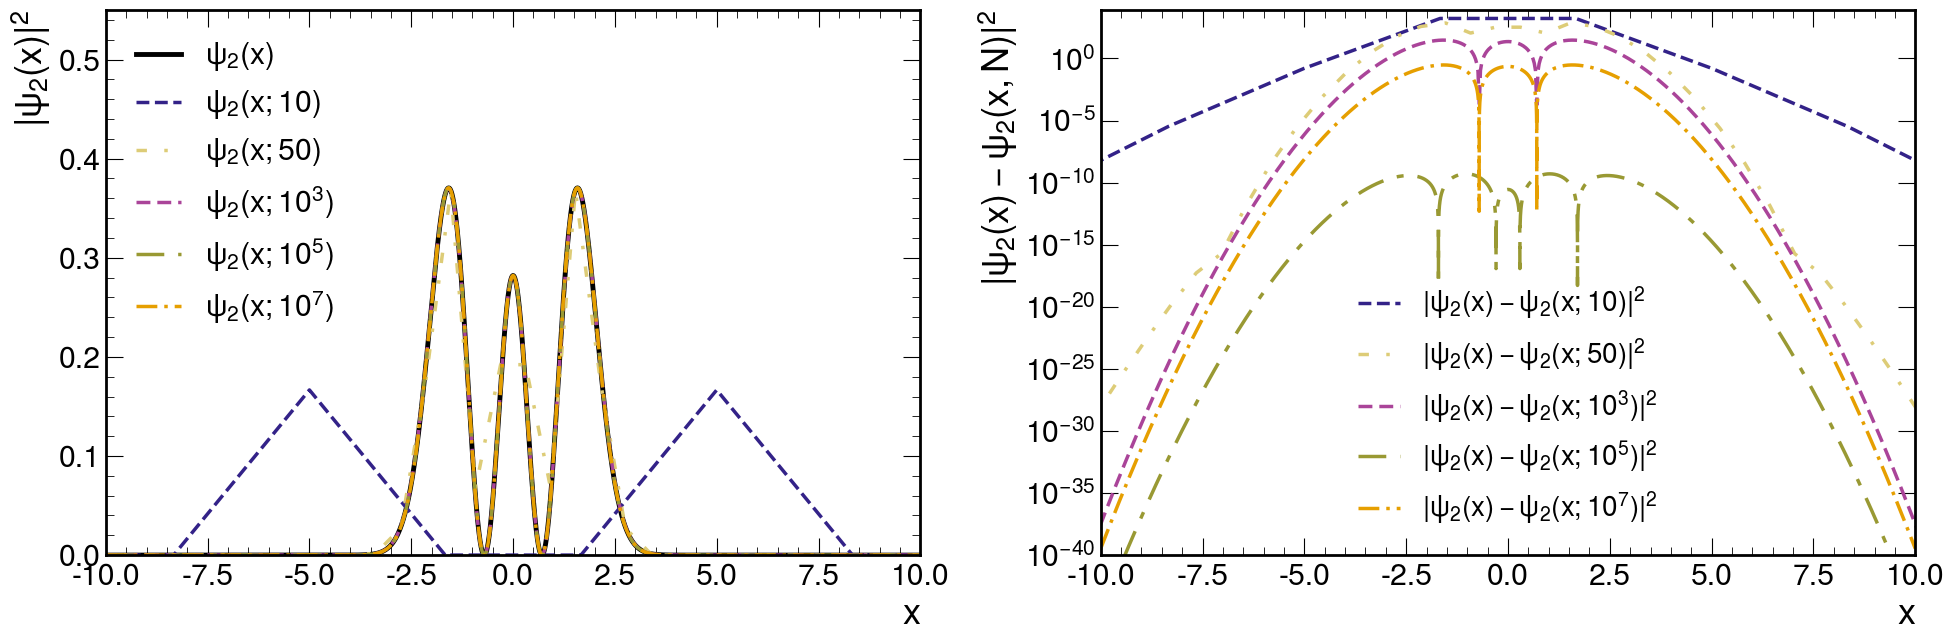

In [380]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

n_state = 2 #n-th eigenstate to compare exact and discrete versions for

x_plot = np.linspace(a,b,int(1e5))
y_plot = 2.5e-5*harmonic_oscillator(x_plot)

def true_ho_n_state(x,n: int): return (np.exp(-0.5*np.power(x,2))* sp.special.hermite(n)(x))/ np.sqrt(2**n * sp.special.factorial(n+5) * np.sqrt(np.pi))

exact_ho_norm = np.sqrt(np.sum(np.power(true_ho_n_state(x_plot,n_state),2)))
normalized_ho_exact_square = np.power(true_ho_n_state(x_plot,n_state)/(np.sqrt((b-a)/1e5)*exact_ho_norm),2)
axs[0].plot(x_plot,normalized_ho_exact_square,color='black',linewidth=3.5,label=r'$\psi_'+f'{n_state}'+'(x)$')

for i in [0,4,6,8,-1]:
    state = discrete_HO_estates[i][n_state]
    state = np.power(state/np.sqrt((b-a)/Ns[i]),2)
    axs[0].plot(np.linspace(a,b,len(state)),state,label=r'$\psi_'+f'{n_state}'+'(x;$'+f'{NStrings[i]})',linestyle=linestyles[i],linewidth=2.5,color=colors[i])

axs[0].legend(loc='upper left');
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$|\psi_'+f'{n_state}'+r'(x)|^2$')
axs[0].set_xlim([-10,10])
axs[0].set_ylim([0,0.55])


for i in [0,4,6,8,-1]:
    state = discrete_HO_estates[i][n_state]
    state = state/np.sqrt((b-a)/Ns[i])

    x_plot = np.linspace(a,b,int(Ns[i]))    

    exact_ho_norm = np.sqrt(np.sum(np.power(true_ho_n_state(x_plot,n_state),2)))
    normalized_ho_exact_square = true_ho_n_state(x_plot,n_state)/(np.sqrt((b-a)/1e5)*exact_ho_norm)

    axs[1].plot(x_plot,np.power(np.abs(state-normalized_ho_exact_square),2),linestyle=linestyles[i],linewidth=2.5,color=colors[i],label=r'$|\psi_'+f'{n_state}'+r'(x)-'+r'\psi_'+f'{n_state}'+'(x;$'+f'{NStrings[i]})$|^2$')


axs[1].set_xlim([-10,10])
axs[1].set_yscale('log')
axs[1].set_ylim([1e-40,8e3])
axs[1].legend(loc='lower center',fontsize=20)
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$|\psi_'+f'{n_state}'+r'(x)-\psi_'+f'{n_state}'+r'(x,N)|^2$')
plt.tight_layout()
plt.savefig('figures/ho-estate-appendix.pdf')

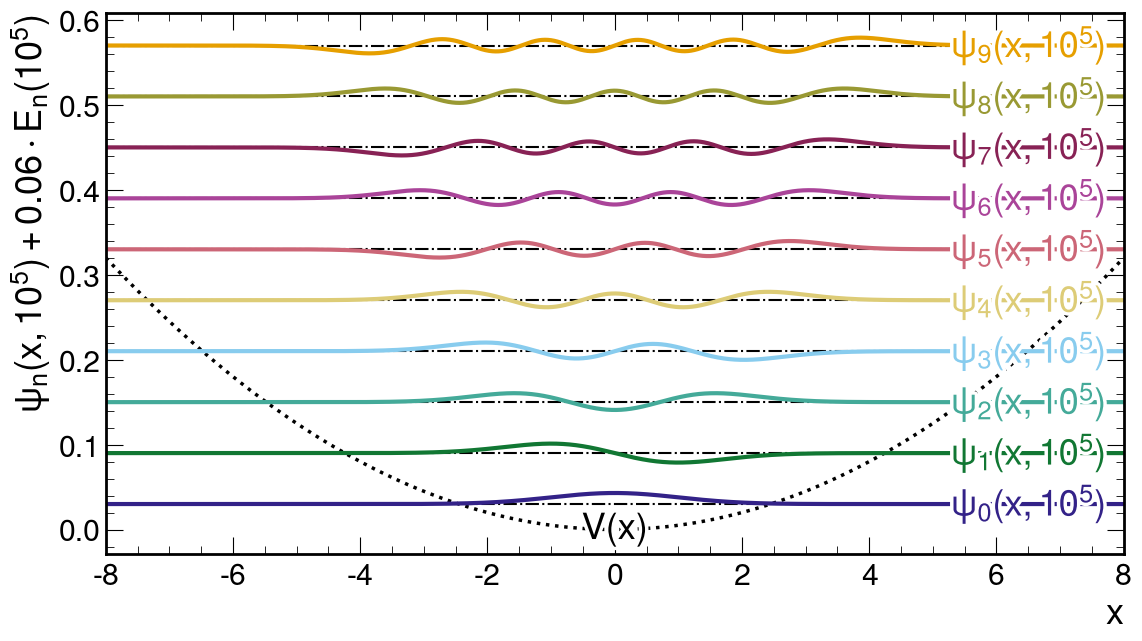

In [72]:
fig = plt.figure(figsize=(12,7))

x_plot = np.linspace(-8,8,int(1e3))
y_plot = 0.01*harmonic_oscillator(x_plot)

for i in range(len(true_ho_vals)):
    plt.axhline(0.06*true_ho_vals[i],color='black',linewidth=1.5,linestyle='-.',label=' ')

plt.plot(x_plot,y_plot,color='black',linestyle=':',linewidth=2.5,label='V(x)')

for i in range(len(discrete_HO_estates[8])):
    state = discrete_HO_estates[8][i] + 0.06 * discrete_HO_evalues[8][i] * np.ones(len(discrete_HO_estates[8][i]))
    plt.plot(np.linspace(a,b,len(state)),state,label=r'$\psi_' +f'{i}'+'(x,10^5)$',linestyle='-',linewidth=3, color=colors[i])
    
labellines.labelLines(plt.gca().get_lines(),align=True,xvals=[0]*(len(true_ho_vals)+1)+[6.5]*len(discrete_HO_estates[0]))
plt.xlim([-8,8])
plt.xlabel('x')
plt.ylabel(r'$\psi_n(x,10^5)+0.06 \cdot E_n(10^5)$')
plt.tight_layout()
plt.savefig('figures/ho-estates.pdf')

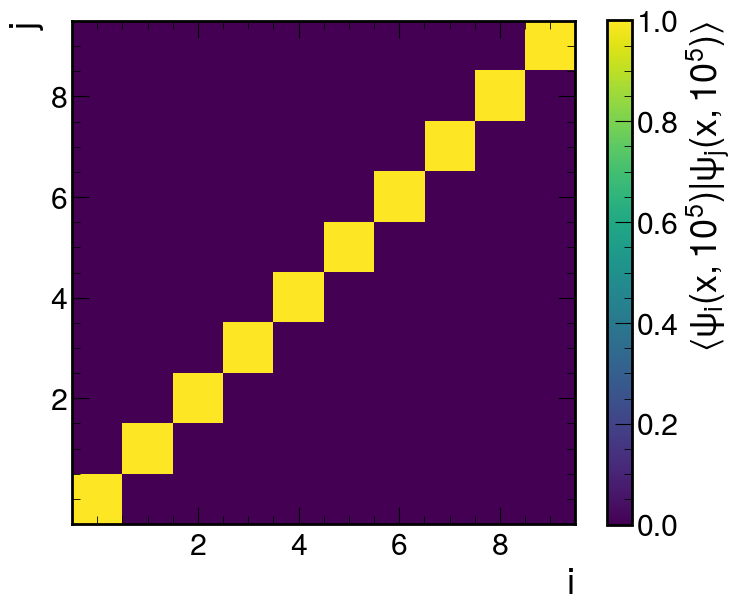

In [70]:
fig = plt.figure(figsize=(8,7))

states = discrete_HO_estates[8]

A = np.zeros((len(states),len(states)))

for i in range(len(states)):
    for j in range(len(states)):
        A[i,j] = np.dot(states[i],states[j])

plt.imshow(A,cmap='viridis')
plt.gca().invert_yaxis()

cbar = plt.colorbar(orientation='vertical',shrink=0.89)
cbar.set_label(r'$\langle \psi_i(x,10^5)|\psi_j(x,10^5)\rangle$')

plt.xticks([2,4,6,8])
plt.yticks([2,4,6,8])
plt.xlabel('i')
plt.ylabel('j')
plt.tight_layout()
plt.savefig('figures/ho-orthonormality.pdf')

## Double Well Potential

In [383]:
a = -15
b = 15
n = 10
m = 1

def double_well(x,k): return np.power(x,2) + 8 * np.exp(-1*np.power(k*x,4))

Ns = np.array([int(x) for x in [10,20,30,40,50,1e2,1e3,1e4,1e5]])

discrete_dw_evalues_k4  = []
discrete_dw_estates_k4  = []
discrete_dw_evalues_k1  = []
discrete_dw_estates_k1  = []

for N in Ns:
    dw_vals, dw_states = discretized_schrodinger(lambda x: double_well(x, k=4),
                                                a,
                                                b,
                                                N,
                                                n,
                                                m)
    discrete_dw_evalues_k4.append(dw_vals)
    discrete_dw_estates_k4.append(dw_states)

    dw_vals, dw_states = discretized_schrodinger(lambda x: double_well(x, k=1),
                                                a,
                                                b,
                                                N,
                                                n,
                                                m)
    discrete_dw_evalues_k1.append(dw_vals)
    discrete_dw_estates_k1.append(dw_states)

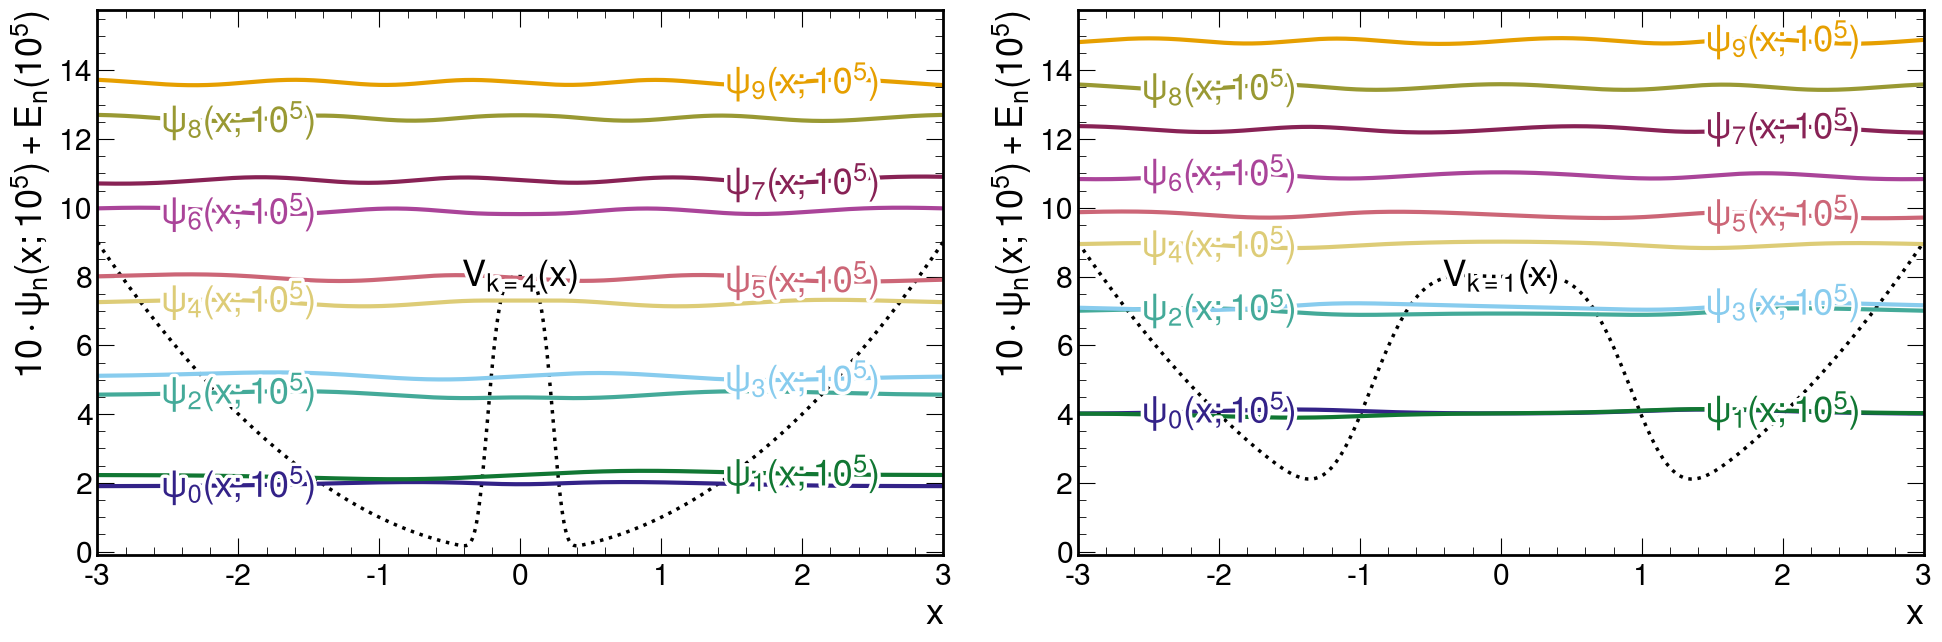

In [346]:
fig, axs = plt.subplots(1,2,figsize=(20,7))
x_plot  = np.linspace(-3,3,int(1e3))

y_plot0 = double_well(x_plot,k=4)

lines0 = []
lines0.extend(axs[0].plot(x_plot,y_plot0,color='black',linestyle=':',linewidth=2.5,label=r'$V_{k=4}(x)$'))

for i in range(len(discrete_dw_estates_k4[-1])):
    state = 10*discrete_dw_estates_k4[-1][i] + discrete_dw_evalues_k4[8][i] * np.ones(len(discrete_dw_estates_k4[-1][i]))
    lines0.extend(axs[0].plot(np.linspace(a,b,len(state)),state,label=r'$\psi_' +f'{i}'+'(x;10^5)$',linestyle='-',linewidth=3, color=colors[i]))
labellines.labelLines(lines0,xvals=[0]+[2*(-1)**i for i in range(1,len(lines0)+1)],align=False)

axs[0].set_xlim([-3,3])
axs[0].set_ylim([-0.1,15.75])
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$10\cdot\psi_n(x;10^5) + E_n(10^5)$')


y_plot1 = double_well(x_plot,k=1)

lines1 = []
lines1.extend(axs[1].plot(x_plot,y_plot1,color='black',linestyle=':',linewidth=2.5,label=r'$V_{k=1}(x)$'))

for i in range(len(discrete_dw_estates_k1[-1])):
    state = 10*discrete_dw_estates_k1[-1][i] + discrete_dw_evalues_k1[8][i] * np.ones(len(discrete_dw_estates_k1[-1][i]))
    lines1.extend(axs[1].plot(np.linspace(a,b,len(state)),state,label=r'$\psi_' +f'{i}'+'(x;10^5)$',linestyle='-',linewidth=3, color=colors[i]))
labellines.labelLines(lines1,xvals=[0]+[2*(-1)**i for i in range(1,len(lines1)+1)],align=False)

axs[1].set_xlim([-3,3])
axs[1].set_ylim([-0.1,15.75])
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$10\cdot\psi_n(x;10^5) + E_n(10^5)$')

plt.tight_layout()
plt.savefig('figures/dw-estates.pdf')

## Hydrogen Atom

In [37]:
a = 0
b = 100
n = 5
m = 1
e = 1

def hydrogen_atom(r,l): return -e**2/r + l*(l+1)/(2*m) * np.power(r,-2.0)

N = int(1e5)

discrete_hy_evalues  = []
discrete_hy_estates  = []

for l in range(0,3):
    hy_vals, hy_states = discretized_schrodinger(lambda x: hydrogen_atom(x, l=l),
                                                a,
                                                b,
                                                N,
                                                n,
                                                m)
    discrete_hy_evalues.append(hy_vals)
    discrete_hy_estates.append(hy_states)

/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/3014972831.py:7: RuntimeWarning: divide by zero encountered in divide
  def hydrogen_atom(r,l): return -e**2/r + l*(l+1)/(2*m) * np.power(r,-2.0)
/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/3014972831.py:7: RuntimeWarning: divide by zero encountered in power
  def hydrogen_atom(r,l): return -e**2/r + l*(l+1)/(2*m) * np.power(r,-2.0)
/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/3014972831.py:7: RuntimeWarning: invalid value encountered in multiply
  def hydrogen_atom(r,l): return -e**2/r + l*(l+1)/(2*m) * np.power(r,-2.0)
/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/3014972831.py:7: RuntimeWarning: invalid value encountered in add
  def hydrogen_atom(r,l): return -e**2/r + l*(l+1)/(2*m) * np.power(r,-2.0)


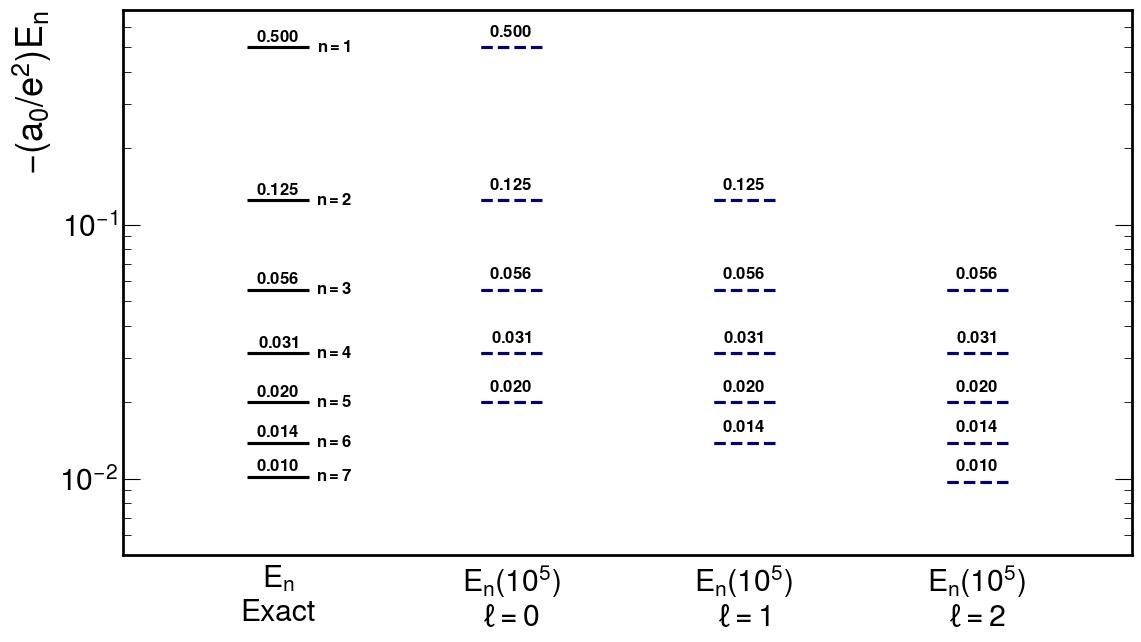

In [63]:
fig, ax = plt.subplots(figsize=(12,7))

real_energies = [e**2/(2*n**2) for n in range(1,8)]

ax.tick_params(top=False,bottom=False)
ax.minorticks_off()

shift_right = 0.15


plt.scatter([shift_right]*len(real_energies),real_energies,marker="_",linewidth=2.25,s=2000,color='black',linestyle='-',label='Experimental Data')
for y in range(len(real_energies)):
    plt.text(shift_right, real_energies[y]*1.05, f"${real_energies[y]:.3f}$", fontsize=12, ha='center', color='black',fontweight='bold')
    plt.text(shift_right+0.036, real_energies[y]*0.96, f"$n={y+1}$", fontsize=12, ha='center', color='black',fontweight='bold')

for x in range(len(discrete_hy_evalues)):
    masses = -1.0*np.array(discrete_hy_evalues[x])
    if x==0:
        plt.scatter([shift_right*(x+2)]*len(masses),masses,marker="_",linewidth=2.25,s=2000,color='navy',linestyle='--',label='$E_n(10^5)$')
    else:
        plt.scatter([shift_right*(x+2)]*len(masses),masses,marker="_",linewidth=2.25,s=2000,color='navy',linestyle='--')

    for y in range(len(masses)):
        plt.text(shift_right*(x+2), masses[y]*1.1, f"${masses[y]:.3f}$", fontsize=12, ha='center', color='black',fontweight='bold')


plt.xticks(np.arange(shift_right,5*shift_right,shift_right),labels=[r'$E_n$'+'\nExact',r'$E_n(10^5)$'+'\n'+r'$\ell=0$',r'$E_n(10^5)$'+'\n'+r'$\ell=1$',r'$E_n(10^5)$'+'\n'+r'$\ell=2$'])
plt.xlim([0.05,0.7])
plt.ylim([5e-3,0.7])
plt.yscale('log')
plt.ylabel(r'$-(a_0/e^2) E_n$')

plt.tight_layout()
plt.savefig('figures/hy-spectrum.pdf')

## Charmonium

In [54]:
a       = 0
b       = 100
n       = 5
m       = 1.273/2 #GeV, Reduced mass for 2 charm quark system
alpha_s = 6 #GeV^2, approximately 1 GeV per fm

def charmonium(r,l): return r/alpha_s+ l*(l+1)/(2*m) * np.power(r,-2.0)

N = int(1e5)

discrete_cc_evalues  = []
discrete_cc_estates  = []

for l in range(0,3):
    cc_vals, cc_states = discretized_schrodinger(lambda x: charmonium(x, l=l),
                                                a,
                                                b,
                                                N,
                                                n,
                                                m)
    discrete_cc_evalues.append(cc_vals)
    discrete_cc_estates.append(cc_states)

/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/1583130762.py:7: RuntimeWarning: divide by zero encountered in power
  def charmonium(r,l): return r/alpha_s+ l*(l+1)/(2*m) * np.power(r,-2.0)
/var/folders/sv/m_8r8y0x1l39dxkt7qky665c0000gn/T/ipykernel_88318/1583130762.py:7: RuntimeWarning: invalid value encountered in multiply
  def charmonium(r,l): return r/alpha_s+ l*(l+1)/(2*m) * np.power(r,-2.0)


In [58]:
orbitals = ['S','P','D','F']

for row,orbit in zip(discrete_cc_evalues,orbitals):
    print(orbit+':', [np.round(x+4*m,4) for x in row])

S: [3.1994, 3.6883, 4.0887, 4.4425, 4.7659]
P: [3.4853, 3.9109, 4.2807, 4.6154, 4.9255]
D: [3.7331, 4.1192, 4.4654, 4.7842, 5.0825]
0.6365


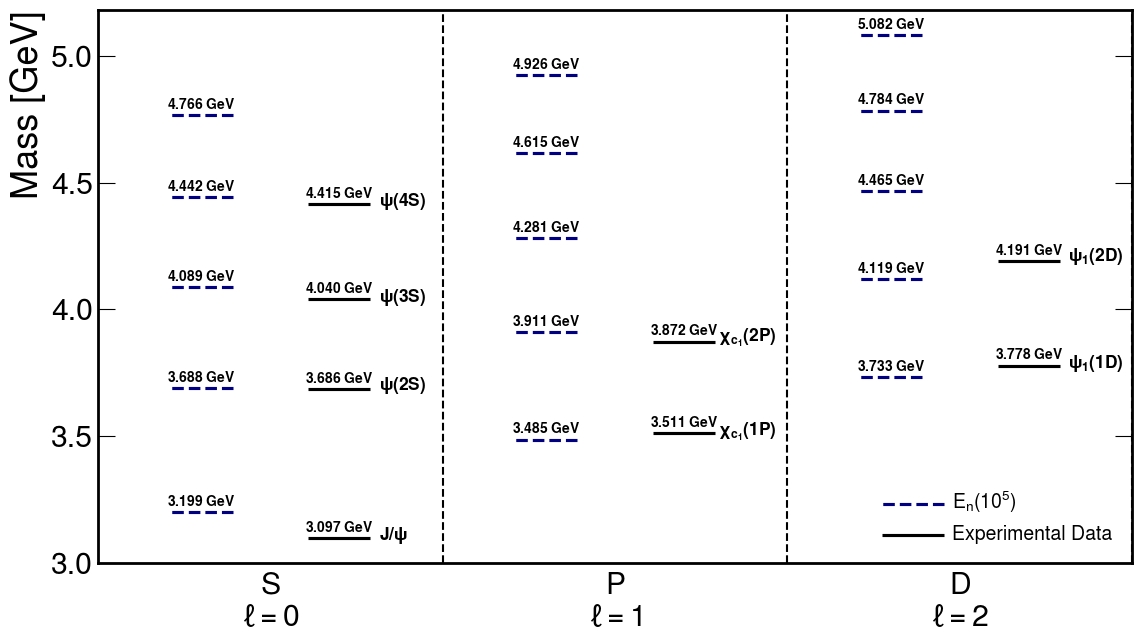

In [64]:
real_s_masses = [3.097,3.686,4.040,4.415]
real_p_masses = [3.511,3.872]
real_d_masses = [3.778,4.191]

real_masses   = [real_s_masses,real_p_masses,real_d_masses]

fig, ax = plt.subplots(figsize=(12,7))

ax.tick_params(top=False,bottom=False)
ax.minorticks_off()

shift_left  = 0.3
shift_right = 0.7

for x in range(len(discrete_cc_evalues)):
    masses = (4*m*np.ones(len(discrete_cc_evalues[x]))+discrete_cc_evalues[x])[:5]
    if x==0:
        plt.scatter([shift_left+x]*len(masses),masses,marker="_",linewidth=2.25,s=2000,color='navy',linestyle='--',label='$E_n(10^5)$')
    else:
        plt.scatter([shift_left+x]*len(masses),masses,marker="_",linewidth=2.25,s=2000,color='navy',linestyle='--')

    for y_val in masses:
        plt.text(shift_left + x, y_val + 0.025, f"${y_val:.3f}$ GeV", fontsize=10, ha='center', color='black',fontweight='bold')

for x in range(len(real_masses)):
    if x==0:
        plt.scatter([shift_right+x]*len(real_masses[x]),real_masses[x],marker="_",linewidth=2.25,s=2000,color='black',linestyle='-',label='Experimental Data')
    else:
        plt.scatter([shift_right+x]*len(real_masses[x]),real_masses[x],marker="_",linewidth=2.25,s=2000,color='black',linestyle='-')

    for y_val in real_masses[x]:
        plt.text(shift_right + x, y_val + 0.025, f"${y_val:.3f}$ GeV", fontsize=10, ha='center', color='black',fontweight='bold')

from matplotlib import font_manager
custom_font = font_manager.FontProperties(family='serif', style='normal', size=14)

plt.text(0.815, 3.09, r"$J/\psi$",   fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')
plt.text(0.815, 3.68, r"$\psi(2S)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')
plt.text(0.815, 4.03, r"$\psi(3S)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')
plt.text(0.815, 4.41, r"$\psi(4S)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')

plt.text(1.80, 3.50, r"$\chi_{c_1}(1P)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')
plt.text(1.80, 3.87, r"$\chi_{c_1}(2P)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')

plt.text(2.815, 3.77, r"$\psi_1(1D)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')
plt.text(2.815, 4.19, r"$\psi_1(2D)$", fontsize=12.5, ha='left', color='black',math_fontfamily='dejavuserif',fontweight='bold')

for x in range(1,4):
    plt.axvline(x,color='black',linestyle='--')

plt.xlim([0,3])
plt.yticks([3,3.5,4,4.5,5])
plt.xticks([0.5,1.5,2.5],labels=['S\n'+r'$\ell=0$','P\n'+r'$\ell=1$','D\n'+r'$\ell=2$'])
plt.ylabel('Mass [GeV]')
plt.legend(loc='lower right',fontsize=14,handletextpad=1.25)
plt.tight_layout()

plt.savefig('figures/cc-mass-spectrum.pdf')